In [1]:
from pr2_utils import *
import gtsam
from gtsam.symbol_shorthand import T  # Pose variable
from gtsam import NonlinearFactorGraph, Values, Pose2, BetweenFactorPose2, Rot2

In [2]:
dataset = 20
odo_str = "icp"

with np.load(f"../data/Hokuyo{dataset}.npz") as data:
    lidar_ranges = data["ranges"].T       # range data [m] (Note: values < range_min or > range_max should be discarded)
    lidar_stamps = data["time_stamps"]  # acquisition times of the lidar scans

with np.load(f"../data/odometry_icp_{dataset}.npz") as data:
    icp_odometry = data["X"]
    icp_odometry_stamp = data["stamps"]

with np.load(f"../data/odometry_imu_{dataset}.npz") as data:
    imu_odometry = data["X"]
    imu_odometry_stamp = data["stamps"]

f_imu_odometry = InterpN1D(imu_odometry_stamp, imu_odometry)

In [15]:
graph = NonlinearFactorGraph()

initial_estimate = Values()
for i, t in enumerate(icp_odometry_stamp):
    initial_estimate.insert(T(i), Pose2(*f_imu_odometry(t)))

# Add a prior for the first pose, assuming we start at the origin with no uncertainty
graph.add(gtsam.PriorFactorPose2(T(0), Pose2(0, 0, 0), gtsam.noiseModel.Diagonal.Sigmas([0, 0, 0])))

icp_noise = gtsam.noiseModel.Diagonal.Sigmas([0.05, 0.05, 0.01])
icp_delta_odometry = icp_odometry[1:] - icp_odometry[:-1]
for i, icp_delta_odo in enumerate(icp_delta_odometry):
    delta_pose = Pose2(*icp_delta_odo)
    graph.add(BetweenFactorPose2(T(i), T(i+1), delta_pose, icp_noise))

# imu_noise = gtsam.noiseModel.Diagonal.Sigmas([0.05, 0.05, 0.01])
# for i in range(icp_odometry_stamp.shape[0]-1):
#     delta_pose = f_imu_odometry(icp_odometry_stamp[i+1]) - f_imu_odometry(icp_odometry_stamp[i])
#     delta_pose = Pose2(*delta_pose)
#     graph.add(BetweenFactorPose2(T(i), T(i+1), delta_pose, imu_noise))

In [16]:
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate)
result = optimizer.optimize()

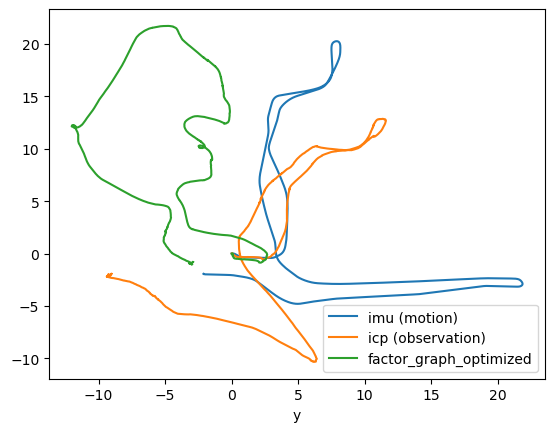

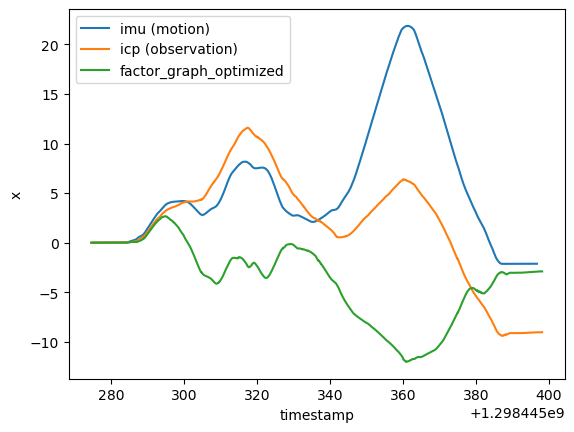

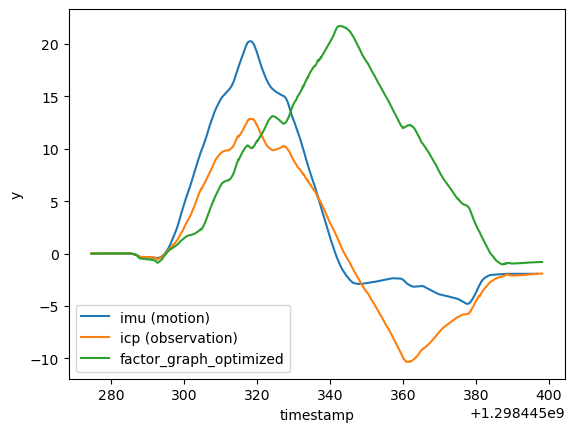

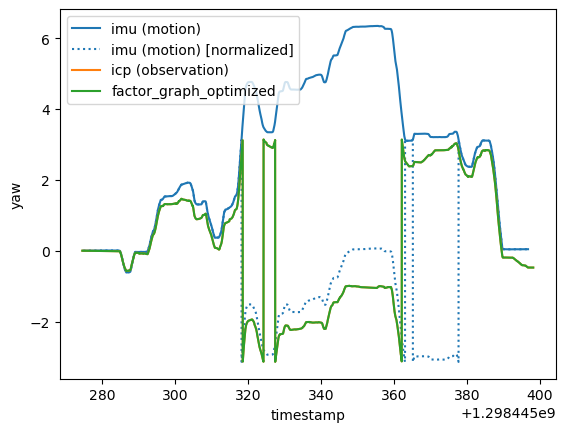

In [17]:
factor_graph_optimized = []
for i in range(icp_odometry_stamp.shape[0]):
    pose = result.atPose2(T(i))
    factor_graph_optimized.append([pose.x(), pose.y(), pose.theta()])
factor_graph_optimized = np.array(factor_graph_optimized)

plot_odometry([
    (imu_odometry, imu_odometry_stamp, "imu (motion)"),
    (icp_odometry, icp_odometry_stamp, "icp (observation)"),
    (factor_graph_optimized, icp_odometry_stamp, "factor_graph_optimized")
])

In [6]:
icp_odometry_stamp.shape[0]

4962

In [7]:
type(result.atPose2(T(1)))

gtsam.gtsam.Pose2